In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import linearmodels as lm
import matplotlib
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import FirstDifferenceOLS
from linearmodels.panel import compare
from matplotlib import pyplot as plt

from pandas.api.types import is_numeric_dtype

pd.set_option('display.max_columns', 500)

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# read the main data set
df=pd.read_csv('estimation_file.csv',
                    encoding='utf-8')


C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (5,144) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# read in and join the maintenance and restructure data
mr=pd.read_csv('maintenance_restructure.csv',
                    encoding='utf-8')
mr = mr[['CBSA', 'Mode', 'Year', 'MAINTENANCE', 'MAINTENANCE_NYC', 'MAINTENANCE_WMATA', 'RESTRUCTURE']]

df = df.merge(mr, on=['CBSA', 'Mode', 'Year'], how='left')

In [4]:
# exclude if ridership is zero--missing data
df = df[df['UPT_ADJ']>0]

In [5]:
# exclude problematic data
old_len = len(df)
df = df[df['VRM_ADJ']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with missing VRM') 

# exclude problematic data
old_len = len(df)
df = df[df['FARE_per_UPT_2018']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with zero or negative fare') 

# exclude problematic data
old_len = len(df)
df = df[df['FARE_per_UPT_2018']<20]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with fare greater than $20') 

# exclude problematic data
old_len = len(df)
df = df[df['HH_0Veh']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with negative 0 veh HH') 


Excluding 3 records with missing VRM
Excluding 78 records with zero or negative fare
Excluding 11 records with fare greater than $20
Excluding 30 records with negative 0 veh HH


In [6]:
# exclude discontinuous data
df = df.sort_values(by=['CBSA', 'Mode', 'Year'])

excluded_records = 100
while excluded_records > 0: 
    old_len = len(df)
    df['YearDiff'] = df['Year'].shift(-1) - df['Year']
    df = df[(df['YearDiff']==1) | (df['Year']==2018)]
    excluded_records = old_len - len(df)
    print('Excluding ' + str(excluded_records) + ' records with discontinuities in year.') 



Excluding 20 records with discontinuities in year.
Excluding 15 records with discontinuities in year.
Excluding 13 records with discontinuities in year.
Excluding 13 records with discontinuities in year.
Excluding 11 records with discontinuities in year.
Excluding 11 records with discontinuities in year.
Excluding 9 records with discontinuities in year.
Excluding 9 records with discontinuities in year.
Excluding 9 records with discontinuities in year.
Excluding 7 records with discontinuities in year.
Excluding 6 records with discontinuities in year.
Excluding 5 records with discontinuities in year.
Excluding 5 records with discontinuities in year.
Excluding 4 records with discontinuities in year.
Excluding 4 records with discontinuities in year.
Excluding 2 records with discontinuities in year.
Excluding 0 records with discontinuities in year.


In [7]:
df['BUS_FLAG'] = np.where(df['Mode']=='Bus', 1, 0)
df['RAIL_FLAG'] = np.where(df['Mode']=='Rail', 1, 0)

In [8]:
# include population + employment
df['POP_EMP'] = df['Tot_Pop'] + df['TOT_EMP_MSA']
df['HH_EMP'] = df['Total_HH'] + df['TOT_EMP_MSA']

# percent of population in transit supportive density
df['TSD_POP_PCT'] = df['POP_CENSUSTRACT'] / df['Tot_Pop']

# percent of pop born outside USA
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100


In [9]:
# mode specific effects

df['Bus_VRM_ADJ_RAIL']  = df['Bus_VRM_ADJ'] * df['RAIL_FLAG']
df['Rail_VRM_ADJ_BUS'] = df['Rail_VRM_ADJ']  * df['BUS_FLAG']

df['Bus_VRM_ADJ_RAIL_log'] = np.log(1+df['Bus_VRM_ADJ_RAIL'])
df['Rail_VRM_ADJ_BUS_log'] = np.log(1+df['Rail_VRM_ADJ_BUS'])


In [10]:
# time effects
df['YEARS_SINCE_2002']  = df['Year'] - 2002

df['YEARS_2002_2010']  = df['Year'].apply(lambda x : min(x-2002, 8))
df['YEARS_AFTER_2010'] = df['Year'].apply(lambda x : max(x-2010, 0))

df['YEARS_2002_2014']  = df['Year'].apply(lambda x : min(x-2002, 12))
df['YEARS_AFTER_2014'] = df['Year'].apply(lambda x : max(x-2014, 0))


df['YEARS_SINCE_2002_BUS']  = df['YEARS_SINCE_2002'] * df['BUS_FLAG']
df['YEARS_SINCE_2002_RAIL'] = df['YEARS_SINCE_2002'] * df['RAIL_FLAG']

df['YEARS_2002_2010_BUS']   = df['YEARS_2002_2010'] * df['BUS_FLAG']
df['YEARS_AFTER_2010_BUS']  = df['YEARS_AFTER_2010']* df['BUS_FLAG']
df['YEARS_2002_2010_RAIL']  = df['YEARS_2002_2010'] * df['RAIL_FLAG']
df['YEARS_AFTER_2010_RAIL'] = df['YEARS_AFTER_2010']* df['RAIL_FLAG']

df['YEARS_2002_2014_BUS']   = df['YEARS_2002_2014'] * df['BUS_FLAG']
df['YEARS_AFTER_2014_BUS']  = df['YEARS_AFTER_2014']* df['BUS_FLAG']
df['YEARS_2002_2014_RAIL']  = df['YEARS_2002_2014'] * df['RAIL_FLAG']
df['YEARS_AFTER_2014_RAIL'] = df['YEARS_AFTER_2014']* df['RAIL_FLAG']

In [11]:
# calculate bus vs rail stuff

# various bus/rail specifics

df['TNC_FLAG_BUS'] = df['TNC_FLAG'] * df['BUS_FLAG']
df['TNC_FLAG_RAIL'] = df['TNC_FLAG'] * df['RAIL_FLAG']

df['YEARS_SINCE_TNC_BUS'] = df['YEARS_SINCE_TNC'] * df['BUS_FLAG']
df['YEARS_SINCE_TNC_RAIL'] = df['YEARS_SINCE_TNC'] * df['RAIL_FLAG']

df['dockless_flag'] = df['dockCt'].apply(lambda x : min(x,1))
df['scooter_flag']  = df['scooterCt'].apply(lambda x : min(x,1))

df['BIKE_SHARE'] = df['PBS_Flag'] + df['dockless_flag']
df['BIKE_SHARE'] = df['BIKE_SHARE'].apply(lambda x : min(x,1))


df['PBS_Flag_BUS']   = df['PBS_Flag']   * df['BUS_FLAG']
df['dockCt_BUS']     = df['dockCt']     * df['BUS_FLAG']
df['docklessCt_BUS'] = df['docklessCt'] * df['BUS_FLAG']
df['scooterCt_BUS']  = df['scooterCt']  * df['BUS_FLAG']
df['dockless_flag_BUS'] = df['dockless_flag'] * df['BUS_FLAG']
df['scooter_flag_BUS']  = df['scooter_flag']  * df['BUS_FLAG']
df['BIKE_SHARE_BUS']  = df['BIKE_SHARE']  * df['BUS_FLAG']


df['PBS_Flag_RAIL']   = df['PBS_Flag']   * df['RAIL_FLAG']
df['dockCt_RAIL']     = df['dockCt']     * df['RAIL_FLAG']
df['docklessCt_RAIL'] = df['docklessCt'] * df['RAIL_FLAG']
df['scooterCt_RAIL']  = df['scooterCt']  * df['RAIL_FLAG']
df['dockless_flag_RAIL'] = df['dockless_flag'] * df['RAIL_FLAG']
df['scooter_flag_RAIL']  = df['scooter_flag']  * df['RAIL_FLAG']
df['BIKE_SHARE_RAIL']  = df['BIKE_SHARE']  * df['RAIL_FLAG']




In [12]:
# set the indices
df['ID'] = df['MNAME'] + '-' + df['Mode']
df=df.set_index(['ID','Year'])

In [13]:
# keep only the numeric columns -- the estimation will give an error otherwise
df = df.select_dtypes(include=[np.number])

In [14]:
# create a log of all fields
for col in df.columns:
    df[col+'_log'] = np.log(df[col]+1)
    

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


## Some core model specification tests -- looking at traditional factors

In [15]:
# no time trends

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4916
Estimator:                   PanelOLS   R-squared (Between):              0.9951
No. Observations:                4054   R-squared (Within):               0.4916
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9948
Time:                        16:46:24   Log-likelihood                    937.52
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      610.20
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(6,3787)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             610.20
                            

In [16]:
# with inflation adjusted prices

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5567
Estimator:                   PanelOLS   R-squared (Between):              0.9959
No. Observations:                4054   R-squared (Within):               0.5567
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9961
Time:                        16:46:36   Log-likelihood                    1215.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      792.63
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(6,3787)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             792.63
                            

In [17]:
# separate pop and emp


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + Tot_Pop_log \
                    + TOT_EMP_MSA_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5608
Estimator:                   PanelOLS   R-squared (Between):              0.9936
No. Observations:                4054   R-squared (Within):               0.5608
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9933
Time:                        16:46:37   Log-likelihood                    1234.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      690.67
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(7,3786)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             690.67
                            

In [18]:
# add average speed

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + AVG_SPEED_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5626
Estimator:                   PanelOLS   R-squared (Between):              0.9982
No. Observations:                4054   R-squared (Within):               0.5626
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9982
Time:                        16:46:38   Log-likelihood                    1242.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      695.60
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(7,3786)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             695.60
                            

In [19]:
# add average speed

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + AVG_SPEED \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5569
Estimator:                   PanelOLS   R-squared (Between):              0.9960
No. Observations:                4054   R-squared (Within):               0.5569
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9963
Time:                        16:46:40   Log-likelihood                    1216.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      679.64
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(7,3786)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             679.64
                            

In [20]:
# VRH and VRM

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRH_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5596
Estimator:                   PanelOLS   R-squared (Between):              0.9971
No. Observations:                4054   R-squared (Within):               0.5596
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9972
Time:                        16:46:40   Log-likelihood                    1228.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      687.31
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(7,3786)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             687.31
                            

In [21]:
# VRH and VRM

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRH_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4639
Estimator:                   PanelOLS   R-squared (Between):              0.9968
No. Observations:                4054   R-squared (Within):               0.4639
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9967
Time:                        16:46:42   Log-likelihood                    830.02
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      546.08
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(6,3787)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             546.08
                            

## look at lagging the VRM and the Fares

In [22]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5567
Estimator:                   PanelOLS   R-squared (Between):              0.9959
No. Observations:                4054   R-squared (Within):               0.5567
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9961
Time:                        16:46:45   Log-likelihood                    1215.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      792.63
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(6,3787)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             792.63
                            

## Look at demographics

In [23]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5567
Estimator:                   PanelOLS   R-squared (Between):              0.9959
No. Observations:                4054   R-squared (Within):               0.5567
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9961
Time:                        16:46:47   Log-likelihood                    1215.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      792.63
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(6,3787)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             792.63
                            

In [24]:
# income percentages

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + INC_U35 \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5570
Estimator:                   PanelOLS   R-squared (Between):              0.9984
No. Observations:                4054   R-squared (Within):               0.5570
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9984
Time:                        16:46:48   Log-likelihood                    1216.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      680.08
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(7,3786)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             680.08
                            

In [25]:
# income percentages

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + INC_100P \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5567
Estimator:                   PanelOLS   R-squared (Between):              0.9962
No. Observations:                4054   R-squared (Within):               0.5567
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9964
Time:                        16:46:48   Log-likelihood                    1215.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      679.22
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(7,3786)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             679.22
                            

In [26]:
# median income


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + HH_MED_INC_2018 \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5570
Estimator:                   PanelOLS   R-squared (Between):              0.9953
No. Observations:                4054   R-squared (Within):               0.5570
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9956
Time:                        16:46:49   Log-likelihood                    1217.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      680.14
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(7,3786)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             680.14
                            

In [27]:
# median income -- log


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + HH_MED_INC_2018_log \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5571
Estimator:                   PanelOLS   R-squared (Between):              0.9984
No. Observations:                4054   R-squared (Within):               0.5571
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9983
Time:                        16:46:49   Log-likelihood                    1217.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      680.45
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(7,3786)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             680.45
                            

In [28]:
# mean income


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + HH_MEAN_INC_2018 \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5588
Estimator:                   PanelOLS   R-squared (Between):              0.9921
No. Observations:                4054   R-squared (Within):               0.5588
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9925
Time:                        16:46:50   Log-likelihood                    1225.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      685.09
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(7,3786)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             685.09
                            

In [29]:
# mean income - log


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + HH_MEAN_INC_2018_log \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5592
Estimator:                   PanelOLS   R-squared (Between):              0.9884
No. Observations:                4054   R-squared (Within):               0.5592
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9881
Time:                        16:46:50   Log-likelihood                    1227.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      686.25
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(7,3786)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             686.25
                            

In [30]:
# median personal income

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TOTAL_MED_INC_INDIV_2018 \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5608
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                4054   R-squared (Within):               0.5608
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9983
Time:                        16:46:51   Log-likelihood                    1234.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      690.48
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(7,3786)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             690.48
                            

In [31]:
# median personal income - log

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5626
Estimator:                   PanelOLS   R-squared (Between):              0.9332
No. Observations:                4054   R-squared (Within):               0.5626
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9330
Time:                        16:46:52   Log-likelihood                    1242.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      695.63
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(7,3786)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             695.63
                            

In [32]:
# immigrant population

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5631
Estimator:                   PanelOLS   R-squared (Between):              0.9414
No. Observations:                4054   R-squared (Within):               0.5631
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9411
Time:                        16:46:52   Log-likelihood                    1245.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      609.88
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(8,3785)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             609.88
                            

In [33]:
# immigrant population - log

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5610
Estimator:                   PanelOLS   R-squared (Between):              0.9630
No. Observations:                4009   R-squared (Within):               0.5610
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9628
Time:                        16:46:53   Log-likelihood                    1356.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      597.44
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.360   Distribution:                  F(8,3740)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             597.44
                            

In [34]:
# immigrant population percentage
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5639
Estimator:                   PanelOLS   R-squared (Between):              0.9211
No. Observations:                4054   R-squared (Within):               0.5639
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9208
Time:                        16:46:54   Log-likelihood                    1248.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      611.81
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(8,3785)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             611.81
                            

## bus vs rail competion

In [35]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5639
Estimator:                   PanelOLS   R-squared (Between):              0.9211
No. Observations:                4054   R-squared (Within):               0.5639
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9208
Time:                        16:46:57   Log-likelihood                    1248.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      611.81
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(8,3785)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             611.81
                            

In [36]:
# include VRM on competing modes
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + Bus_VRM_ADJ_RAIL \
                    + Rail_VRM_ADJ_BUS \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


ValueError: exog does not have full column rank.

## TNCs, bikes, scooters

In [37]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5639
Estimator:                   PanelOLS   R-squared (Between):              0.9211
No. Observations:                4054   R-squared (Within):               0.5639
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9208
Time:                        16:47:11   Log-likelihood                    1248.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      611.81
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                  F(8,3785)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             611.81
                            

In [38]:
# add TNC flag

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + TNC_FLAG_BUS \
                    + TNC_FLAG_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5645
Estimator:                   PanelOLS   R-squared (Between):              0.9340
No. Observations:                4054   R-squared (Within):               0.5645
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9337
Time:                        16:47:12   Log-likelihood                    1251.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      490.32
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                 F(10,3783)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             490.32
                            

In [39]:
# add TNC flag

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5694
Estimator:                   PanelOLS   R-squared (Between):              0.9646
No. Observations:                4054   R-squared (Within):               0.5694
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9642
Time:                        16:47:13   Log-likelihood                    1274.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      500.16
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                 F(10,3783)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             500.16
                            

In [40]:
# add BIKE SHARE

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5687
Estimator:                   PanelOLS   R-squared (Between):              0.9981
No. Observations:                3895   R-squared (Within):               0.5687
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9980
Time:                        16:47:14   Log-likelihood                    1270.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      399.35
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(12,3635)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             399.35
                            

In [41]:
# add SCOOTERS

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5691
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                3895   R-squared (Within):               0.5691
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9983
Time:                        16:47:16   Log-likelihood                    1271.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      342.68
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(14,3633)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             342.68
                            

In [42]:
# add dock count

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + dockCt_BUS \
                    + dockCt_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5698
Estimator:                   PanelOLS   R-squared (Between):              0.9679
No. Observations:                4054   R-squared (Within):               0.5698
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9675
Time:                        16:47:20   Log-likelihood                    1276.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      357.53
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.533   Distribution:                 F(14,3779)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             357.53
                            

In [43]:
# current favorite

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5691
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                3895   R-squared (Within):               0.5691
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9983
Time:                        16:47:21   Log-likelihood                    1271.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      342.68
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(14,3633)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             342.68
                            

In [44]:
# bike share plus scooters for rail
df['BIKE_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL']

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5690
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                3895   R-squared (Within):               0.5690
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9982
Time:                        16:47:25   Log-likelihood                    1271.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      369.02
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(13,3634)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             369.02
                            

In [45]:
# different spec of bike and scooter
df['BIKE_SCOOTER_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] + df['scooter_flag_RAIL']

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5690
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                3895   R-squared (Within):               0.5690
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9983
Time:                        16:47:27   Log-likelihood                    1271.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      369.09
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(13,3634)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             369.09
                            

## Maintenance and restructures

In [46]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5690
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                3895   R-squared (Within):               0.5690
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9983
Time:                        16:47:31   Log-likelihood                    1271.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      369.09
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(13,3634)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             369.09
                            

In [47]:
# add bus restructures

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + RESTRUCTURE \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5694
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                3895   R-squared (Within):               0.5694
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9983
Time:                        16:47:35   Log-likelihood                    1273.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      343.13
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(14,3633)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             343.13
                            

In [48]:
# add maintenance issues

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + MAINTENANCE \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5694
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                3895   R-squared (Within):               0.5694
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9982
Time:                        16:47:39   Log-likelihood                    1273.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      343.09
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(14,3633)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             343.09
                            

In [49]:
# restructure and maintenance


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + MAINTENANCE \
                    + RESTRUCTURE \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5697
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                3895   R-squared (Within):               0.5697
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9983
Time:                        16:47:45   Log-likelihood                    1274.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      320.60
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(15,3632)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             320.60
                            

In [50]:
# Split NYC from WMATA on maintenance
# NYC is prefectly correlated with something?

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + MAINTENANCE_WMATA \
                    + MAINTENANCE_NYC \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)




C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5697
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                3895   R-squared (Within):               0.5697
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9983
Time:                        16:47:49   Log-likelihood                    1274.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      320.56
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(15,3632)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             320.56
                            

In [51]:
# Maintenance with just WMATA

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)




C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5696
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                3895   R-squared (Within):               0.5696
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9982
Time:                        16:48:16   Log-likelihood                    1274.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      343.40
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(14,3633)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             343.40
                            

## try time effects

In [52]:
# no time effects

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + MAINTENANCE \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5694
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                3895   R-squared (Within):               0.5694
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9982
Time:                        16:48:20   Log-likelihood                    1273.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      343.09
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(14,3633)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             343.09
                            

In [53]:
# full time effects

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + MAINTENANCE \
                    + EntityEffects \
                    + TimeEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5083
Estimator:                   PanelOLS   R-squared (Between):              0.9939
No. Observations:                3895   R-squared (Within):               0.5622
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9941
Time:                        16:48:21   Log-likelihood                    1327.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      267.10
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(14,3617)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             267.10
                            

In [54]:
# trends

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + MAINTENANCE \
                    + YEARS_SINCE_2002_BUS \
                    + YEARS_SINCE_2002_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5739
Estimator:                   PanelOLS   R-squared (Between):              0.9936
No. Observations:                3895   R-squared (Within):               0.5739
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9934
Time:                        16:48:22   Log-likelihood                    1293.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      305.69
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(16,3631)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             305.69
                            

In [55]:
# split trends

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + MAINTENANCE \
                    + YEARS_2002_2014_BUS \
                    + YEARS_2002_2014_RAIL \
                    + YEARS_AFTER_2014_BUS \
                    + YEARS_AFTER_2014_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5821
Estimator:                   PanelOLS   R-squared (Between):              0.9986
No. Observations:                3895   R-squared (Within):               0.5821
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9985
Time:                        16:48:25   Log-likelihood                    1331.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      280.77
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(18,3629)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             280.77
                            

In [56]:
# it looks best without the time effects

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + MAINTENANCE \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5694
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                3895   R-squared (Within):               0.5694
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9982
Time:                        16:48:27   Log-likelihood                    1273.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      343.09
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(14,3633)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             343.09
                            

## Run some analytics

In [57]:
# bike share plus scooters for rail

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + MAINTENANCE \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5694
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                3895   R-squared (Within):               0.5694
Date:                Fri, Nov 22 2019   R-squared (Overall):              0.9982
Time:                        16:48:33   Log-likelihood                    1273.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      343.09
Entities:                         248   P-value                           0.0000
Avg Obs:                       15.706   Distribution:                 F(14,3633)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             343.09
                            

In [87]:
new_york = df[df['CBSA']==35620]
new_york = new_york[['UPT_ADJ_log', 'VRM_ADJ_log',
'FARE_per_UPT_2018_log',
'POP_EMP_log',
'GAS_PRICE_2018_log',
'TOTAL_MED_INC_INDIV_2018_log',
'Tot_NonUSA_POP_pct',
'PCT_HH_NO_VEH',
'TSD_POP_PCT',
'YEARS_SINCE_TNC_BUS',
'YEARS_SINCE_TNC_RAIL',
'BIKE_SHARE_BUS',
'scooter_flag_BUS',
'BIKE_SCOOTER_SCOOTER_RAIL',
'MAINTENANCE']]
new_york

UPT_ADJ_log  \
ID                                                 Year                
New York-Northern New Jersey-Long Island, NY-NJ... 2002    21.003789   
                                                   2003    20.971580   
                                                   2004    20.977544   
                                                   2005    21.022861   
                                                   2006    20.990183   
                                                   2007    20.951101   
                                                   2008    20.970024   
                                                   2009    20.942441   
                                                   2010    20.924134   
                                                   2011    20.897044   
                                                   2012    20.904478   
                                                   2013    20.907872   
                                                   2014    20.899442   
                                                   2015    20.872094   
                                                   2016    20.873481   
                                                   2017    20.818855   
                                                   2018    20.825339   
New York-Northern New Jersey-Long Island, NY-NJ... 2002    21.430542   
                                                   2003    21.416338   
                                                   2004    21.472393   
                                                   2005    21.642437   
                                                   2006    21.680179   
                                                   2007    21.735240   
                                                   2008    21.759527   
                                                   2009    21.722893   
                                                   2010    21.757440   
                                                   2011    21.779485   
                                                   2012    21.797135   
                                                   2013    21.830455   
                                                   2014    21.865734   
                                                   2015    21.837489   
                                                   2016    21.844829   
                                                   2017    21.851660   
                                                   2018    21.830474   

                                                         VRM_ADJ_log  \
ID                                                 Year                
New York-Northern New Jersey-Long Island, NY-NJ... 2002    19.480210   
                                                   2003    19.416517   
                                                   2004    19.470365   
                                                   2005    19.493619   
                                                   2006    19.419096   
                                                   2007    19.526333   
                                                   2008    19.543176   
                                                   2009    19.558468   
                                                   2010    19.464868   
                                                   2011    19.439136   
                                                   2012    19.433205   
                                                   2013    19.449224   
                                                   2014    19.459635   
                                                   2015    19.451024   
                                                   2016    19.447032   
                                                   2017    19.431631   
                                                   2018    19.428771   
New York-Northern New Jersey-Long Island, NY-NJ... 2002    19.977921   
                        

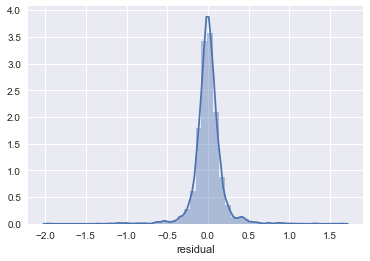

In [58]:
sns.distplot(res.resids)

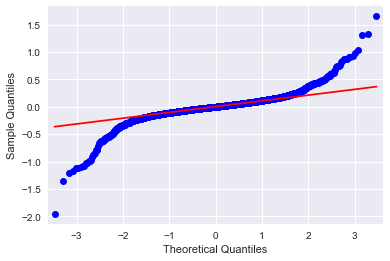

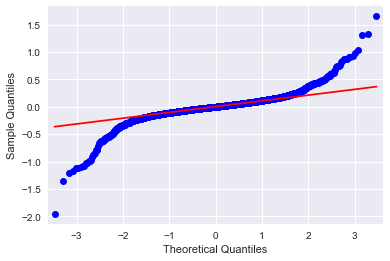

In [59]:
sm.graphics.qqplot(res.resids,line = 'q')

## Calculate FAC

In [60]:
# keep the relevant fields in the data set
app_data = pd.concat([df[['RAIL_FLAG', 'CLUSTER_APTA']], 
                      res.model.dependent.dataframe, 
                      res.model.exog.dataframe, 
                      res.estimated_effects, 
                      res.resids], axis=1)


In [61]:
app_data.head()

RAIL_FLAG  CLUSTER_APTA  UPT_ADJ_log  \
Akron, OH Metro Area-Bus 2002          0            24    15.469231   
                         2003          0            24    15.501150   
                         2004          0            24    15.591676   
                         2005          0            24    15.609548   
                         2006          0            24    15.619001   

                               VRM_ADJ_log  FARE_per_UPT_2018_log  \
Akron, OH Metro Area-Bus 2002    15.208377               0.162997   
                         2003    15.195930               0.502067   
                         2004    15.277699               0.450106   
                         2005    15.214971               0.499830   
                         2006    15.200501               0.501551   

                               POP_EMP_log  GAS_PRICE_2018_log  \
Akron, OH Metro Area-Bus 2002    13.808216            1.066089   
                         2003    13.823451            1.138954   
                         2004    13.839439            1.233697   
                         2005    13.857195            1.361617   
                         2006    13.879496            1.429114   

                               TOTAL_MED_INC_INDIV_2018_log  \
Akron, OH Metro Area-Bus 2002                     10.479210   
                         2003                     10.446267   
                         2004                     10.403980   
                         2005                     10.365663   
                         2006                     10.305856   

                               Tot_NonUSA_POP_pct  PCT_HH_NO_VEH  TSD_POP_PCT  \
Akron, OH Metro Area-Bus 2002           -0.060245           8.60     0.185260   
                         2003            0.114214           8.20     0.180770   
                         2004            0.288851           7.79     0.176377   
                         2005            0.430267           7.47     0.172435   
                         2006            0.669812           6.85     0.167543   

                               YEARS_SINCE_TNC_BUS  YEARS_SINCE_TNC_RAIL  \
Akron, OH Metro Area-Bus 2002                  0.0                   0.0   
                         2003                  0.0                   0.0   
                         2004                  0.0                   0.0   
                         2005                  0.0                   0.0   
                         2006                  0.0                   0.0   

                               BIKE_SHARE_BUS  scooter_flag_BUS  \
Akron, OH Metro Area-Bus 2002             0.0               0.0   
                         2003             0.0               0.0   
                         2004             0.0               0.0   
                         2005             0.0               0.0   
                         2006             0.0               0.0   

                               BIKE_SCOOTER_SCOOTER_RAIL  MAINTENANCE  \
Akron, OH Metro Area-Bus 2002                        0.0          0.0   
                         2003                        0.0          0.0   
                         2004                        0.0          0.0   
                         2005                        0.0          0.0   
                         2006                        0.0          0.0   

                                effects  residual  
Akron, OH Metro Area-Bus 2002  0.085297 -0.263898  
                         2003  0.085297 -0.018044  
                         2004  0.085297 -0.052021  
                         2005  0.085297 -0.009501  
                         2006  0.085297 -0.038558

In [62]:
# calculate the fitted values
app_data['fitted'] = app_data['effects']
for var in res.params.keys(): 
    app_data['fitted'] = app_data['fitted'] + (res.params[var] * app_data[var])

# and check that we add up correctly
app_data['check_fitted'] = app_data['fitted'] + app_data['residual'] - app_data['UPT_ADJ_log']

In [63]:
# create the necessary columns

# dependents
app_data['UPT_ADJ']    = np.exp(app_data['UPT_ADJ_log']) - 1
app_data['fitted_exp'] = np.exp(app_data['fitted']) - 1

# linear versions of logged variables
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '')] = np.exp(app_data[var]) - 1              

# ratios and differences
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '_ratio')] = 1
    else: 
        app_data[var+'_diff'] = 0

# FAC multipliers
for var in res.params.keys(): 
    app_data[var+'_FAC_ratio'] = 1

app_data['UPT_ADJ_base'] = 0
app_data['UPT_ADJ_ratio'] = 1
app_data['fitted_exp_ratio'] = 1
app_data['UPT_ADJ_diff'] = 0
app_data['fitted_exp_diff'] = 0

In [64]:
# calculate the FAC relative to a specific base year
ids = app_data.index.get_level_values(0).unique()

for id in ids: 
    years = app_data.loc[id].index.get_level_values(0)

    for year in years[1:]:       
        base_year = year-1
        
        for var in res.params.keys(): 
            # ratios and differences
            if '_log' in var: 
                out_var = var.replace('_log', '_ratio')
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 / app_data.loc[(id,base_year), var])
            else: 
                out_var = var+'_diff'                    
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 - app_data.loc[(id,base_year), var])

            # FAC multipliers
            app_data.loc[(id,year),var+'_FAC_ratio'] = np.exp(res.params[var] * (
                                                    app_data.loc[(id,year), var] 
                                                    - app_data.loc[(id,base_year), var]))

            # estimated effects (if time effects is zero, no change)
            app_data.loc[(id,year),'effects_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'effects'] 
                                                    - app_data.loc[(id,base_year), 'effects'])

            # residual
            app_data.loc[(id,year),'residual_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'residual'] 
                                                    - app_data.loc[(id,base_year), 'residual'])

        # observed and fitted changes            
        app_data.loc[(id,year),'UPT_ADJ_base'] = app_data.loc[(id,base_year),'UPT_ADJ']
        app_data.loc[(id,year),'UPT_ADJ_ratio'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 / app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_ratio'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 / app_data.loc[(id,base_year),'fitted_exp'])

        app_data.loc[(id,year),'UPT_ADJ_diff'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 - app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_diff'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 - app_data.loc[(id,base_year),'fitted_exp'])


In [65]:
# calculate the total change ratios

app_data['FAC_ratio'] = 1
for var in res.params.keys(): 
    app_data['FAC_ratio'] = app_data['FAC_ratio'] * app_data[var+'_FAC_ratio']
    
app_data['FAC_ratio'] = app_data['FAC_ratio'] * app_data['effects_FAC_ratio']

In [66]:
# calculate the FAC
app_data['Total_FAC'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC'] = (app_data[var+'_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
    app_data['Total_FAC'] = app_data['Total_FAC'] + app_data[var+'_FAC']
app_data['effects_FAC'] = (app_data['effects_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
app_data['Total_FAC'] = app_data['Total_FAC'] + app_data['effects_FAC']

# scale the FAC
app_data['FAC_scale'] = app_data['fitted_exp_diff'] / app_data['Total_FAC']
app_data['FAC_scale'] = app_data['FAC_scale'].fillna(1)

app_data['Total_FAC_scaled'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC_scaled'] = app_data[var+'_FAC'] * app_data['FAC_scale']
    app_data['Total_FAC_scaled'] = app_data['Total_FAC_scaled'] + app_data[var+'_FAC_scaled']
app_data['effects_FAC_scaled'] = app_data[var+'_FAC_scaled'] * app_data['FAC_scale']
app_data['Total_FAC_scaled'] = app_data['Total_FAC_scaled'] + app_data['effects_FAC_scaled']


In [67]:
# calculate APTA - 4 groups
app_data['CLUSTER_APTA4'] = np.floor(app_data['CLUSTER_APTA']/10)

In [68]:
# reset the index so I get ID and year
app_data = app_data.reset_index()
app_data = app_data.rename(columns={'level_0' : 'ID', 'level_1' : 'Year'})
app_data.to_csv('FAC.csv')

In [69]:
# these are the fields we keep
out_fields = ['ID', 'Year', 'RAIL_FLAG', 
              'CLUSTER_APTA', 'CLUSTER_APTA4', 
              'UPT_ADJ_base', 'UPT_ADJ', 'UPT_ADJ_diff', 
              'fitted_exp', 'fitted_exp_diff']

# exogenous variables 
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    out_fields = out_fields + [out_var]
    
# FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC']
out_fields = out_fields + ['Total_FAC']
    
# scaled FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC_scaled']
out_fields = out_fields + ['Total_FAC_scaled']

# keep those fields
summary_data = app_data.reset_index()[out_fields]

In [70]:
# take weighted average of exogenous variables
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data[out_var] = summary_data[out_var] * summary_data['UPT_ADJ_base']

# aggregate to bus/rail totals
summary_data_apta4 = summary_data.groupby(by=['CLUSTER_APTA4', 'RAIL_FLAG', 'Year']).agg('sum')

# divide for weighted averages
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
#    summary_data_gt[out_var] = summary_data_gt[out_var] / summary_data_gt['UPT_ADJ_base']
    summary_data_apta4[out_var] = summary_data_apta4[out_var] / summary_data_apta4['UPT_ADJ_base']
#    summary_data_apta_hml[out_var] = summary_data_apta_hml[out_var] / summary_data_apta_hml['UPT_ADJ_base']
    

In [71]:
#summary_data_gt.to_csv('FAC_totals_GT_CLUSTERS.csv')
summary_data_apta4.to_csv('FAC_totals_APTA4_CLUSTERS.csv')
#summary_data_apta_hml.to_csv('FAC_totals_APTA_HML_CLUSTERS.csv')


In [72]:
summary_data_apta4.head(20)

CLUSTER_APTA  UPT_ADJ_base       UPT_ADJ  \
CLUSTER_APTA4 RAIL_FLAG Year                                             
1.0           0         2002           190  0.000000e+00  2.013179e+09   
                        2003           190  2.013179e+09  2.013821e+09   
                        2004           190  2.013821e+09  2.041333e+09   
                        2005           190  2.041333e+09  2.063005e+09   
                        2006           190  2.063005e+09  2.071799e+09   
                        2007           190  2.071799e+09  2.090532e+09   
                        2008           190  2.090532e+09  2.172421e+09   
                        2009           190  2.172421e+09  2.087737e+09   
                        2010           190  2.087737e+09  2.019401e+09   
                        2011           190  2.019401e+09  2.050938e+09   
                        2012           190  2.050938e+09  2.080704e+09   
                        2013           190  2.080704e+09  2.076741e+09   
                        2014           190  2.076741e+09  2.061719e+09   
                        2015           190  2.061719e+09  2.028750e+09   
                        2016           190  2.028750e+09  1.944705e+09   
                        2017           190  1.944705e+09  1.875434e+09   
                        2018           190  1.875434e+09  1.832288e+09   
              1         2002           160  0.000000e+00  1.246324e+09   
                        2003           160  1.246324e+09  1.241953e+09   
                        2004           180  1.241953e+09  1.312022e+09   

                              UPT_ADJ_diff    fitted_exp  fitted_exp_diff  \
CLUSTER_APTA4 RAIL_FLAG Year                                                
1.0           0         2002  0.000000e+00  1.838609e+09     0.000000e+00   
                        2003  6.425510e+05  1.977204e+09     1.385956e+08   
                        2004  2.751127e+07  2.036158e+09     5.895419e+07   
                        2005  2.167215e+07  2.079982e+09     4.382370e+07   
                        2006  8.794756e+06  2.168543e+09     8.856104e+07   
                        2007  1.873279e+07  2.185304e+09     1.676071e+07   
                        2008  8.188896e+07  2.262602e+09     7.729867e+07   
                        2009 -8.468456e+07  2.124276e+09    -1.383268e+08   
                        2010 -6.833532e+07  2.109231e+09    -1.504501e+07   
                        2011  3.153659e+07  2.128399e+09     1.916813e+07   
                        2012  2.976613e+07  2.108259e+09    -2.013931e+07   
                        2013 -3.963190e+06  2.070719e+09    -3.753995e+07   
                        2014 -1.502232e+07  2.024968e+09    -4.575127e+07   
                        2015 -3.296812e+07  1.908661e+09    -1.163075e+08   
                        2016 -8.404573e+07  1.844544e+09    -6.411681e+07   
                        2017 -6.927050e+07  1.867913e+09     2.336899e+07   
                        2018 -4.314625e+07  1.824342e+09    -4.357104e+07   
              1         2002  0.000000e+00  1.164530e+09     0.000000e+00   
                        2003 -4.370277e+06  1.246321e+09     8.179059e+07   
                        2004  5.943353e+07  1.298451e+09     3.953183e+07   

                                   VRM_ADJ  FARE_per_UPT_2018       POP_EMP  \
CLUSTER_APTA4 RAIL_FLAG Year                                                  
1.0           0         2002           NaN                NaN           NaN   
                        2003  5.248391e+07           0.947098  7.061254e+06   
                        2004  5.326346e+07           0.961235  7.213577e+06   
                        2005  5.197083e+07           0.960603  7.409766e+06   
                        2006  5.206632e+07           0.950030  7.653103e+06   
                        2007  5.340645e+07           0.971221  7.706491e+06   
                        2008  5.411188e+07           0.940380  7.762979e+0